# 3 Components Data

In [12]:
import numpy as np
import time

from ml4pd import components
from ml4pd_utils.utils import prep_dist
from ml4pd.aspen_units import Distillation
from ml4pd.streams import MaterialStream

input_molecules = prep_dist.get_mol_labels()
components.set_components(input_molecules['name'].to_list())

raw_data = prep_dist.get_test_val_data(compositions=[3], dates=['220803', '220821'], chemistries=['ketone', 'vfa'])
data = prep_dist.add_name_columns(raw_data, input_molecules[['name', 'mol']])
data = prep_dist.add_flow_perc(data)
data = prep_dist.rename_flowrate_columns(data)

## Benchmark Data Info

In [13]:
input_molecules.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25
name,water,acetone,2-butanone,3-pentanone,3-hexanone,4-heptanone,4-octanone,5-nonanone,5-decanone,6-undecanone,6-dodecanone,6-tridecanone,7-tetradecanone,8-pentadecanone,acetic acid,propionic acid,lactic acid,n-butyric acid,isobutyric acid,succinic acid,n-valeric acid,isovaleric acid,n-hexanoic acid,n-heptanoic acid,n-octanoic acid
mol,H2O,C3-ONE,C4-ONE,C5-ONE,C6-ONE,C7-ONE,C8-ONE,C9-ONE,C10-ONE,C11-ONE,C12-ONE,C13-ONE,C14-ONE,C15-ONE,C2-VFA-1,C3-VFA-1,C3-VFA-2,C4-VFA-1,C4-VFA-2,C4-VFA-3,C5-VFA-1,C5-VFA-2,C6-VFA-1,C7-VFA-1,C8-VFA-1


In [14]:
raw_data.describe().T

,count,mean,std,min,25%,50%,75%,max
flowrate_feed_A,20000.0,0.332107,0.190534,1.599000e-05,0.184612,0.328951,0.454750,0.997252
flowrate_feed_B,20000.0,0.333419,0.189931,4.498000e-05,0.186380,0.331611,0.455955,0.988334
flowrate_feed_C,20000.0,0.334473,0.191403,4.233000e-05,0.188073,0.330732,0.457897,0.986002
ratio_reflux,20000.0,6.371080,6.334199,1.001860e-02,0.377469,4.245621,11.589979,19.998718
ratio_boilup,20000.0,7.054473,6.297504,1.003633e-02,0.911737,5.631459,12.332263,19.998715
no_stages,20000.0,25.998700,10.299922,2.000000e+00,20.000000,28.000000,34.000000,40.000000
pressure_atm,20000.0,10.835894,9.458596,1.001824e-01,1.627735,8.818100,18.769000,29.998524
vapor_fraction,20000.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
feed_pressure,20000.0,10.835895,9.458596,1.001834e-01,1.627736,8.818101,18.769001,29.998525
feed_stage,20000.0,14.732650,9.804488,1.000000e+00,6.000000,14.000000,22.000000,41.000000


## Time Benchmark

In [15]:
times = []
for i in range(0, 10):
    start_time = time.time()
    feed_stream = MaterialStream(stream_type="feed")(
        vapor_fraction=data['vapor_fraction'].to_list(),
        pressure=data['feed_pressure'].to_list(),
        molecules=prep_dist.get_name_columns(data).to_dict('list'),
        flowrates=prep_dist.get_flowrate_columns(data).to_dict('list'),
    )
    
    dist_col = Distillation(
        no_stages = data['no_stages'].to_list(),
        feed_stage =  data['feed_stage'].to_list(),
        pressure = data['pressure_atm'].to_list(),
        reflux_ratio = data['ratio_reflux'].to_list(),
        boilup_ratio = data['ratio_boilup'].to_list(),
        verbose=False,
        fillna=False
    )

    bott_stream, dist_stream = dist_col(feed_stream)
    
    times.append(time.time() - start_time)

ordered_data = prep_dist.sort_targets_by_weight(data, feed_stream._mw_idx)

average = np.mean(times).round(2)
std = np.std(times).round(2)

print(f"{len(data)} data pts take {average} +/- {std} seconds to predict.")

20000 data pts take 4.42 +/- 0.9 seconds to predict.


## Classifier Benchmark

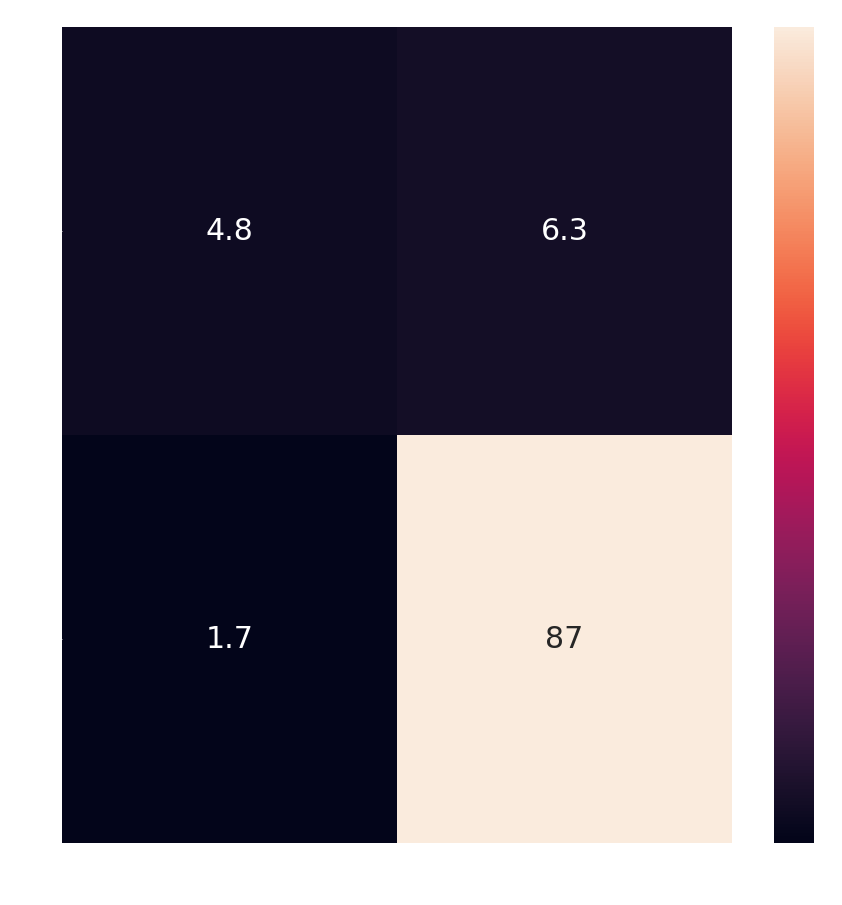

In [16]:
ok_idx = np.array(ordered_data[ordered_data['Status'] == 'OK'].index)
prep_dist.plot_confusion_matrix(ordered_data, dist_col.status)

## Flowrates Benchmark

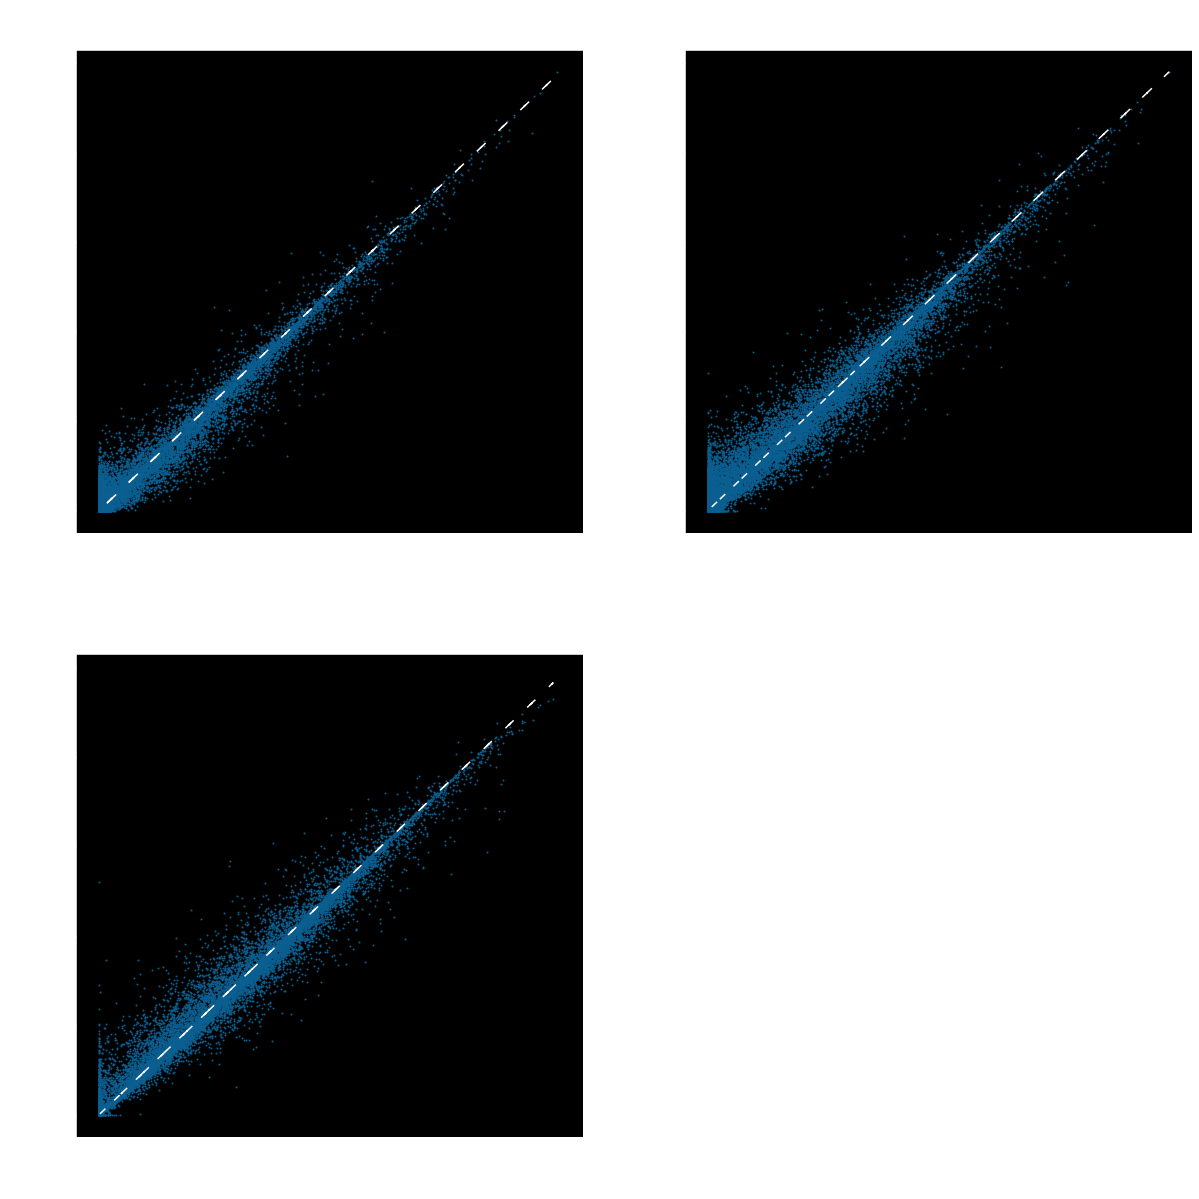

In [17]:
prep_dist.plot_flow(
    all_true=ordered_data,
    y_pred=bott_stream.flow,
    data_slice={
        'Status': 'OK',
    }
)

## Duty Benchmark

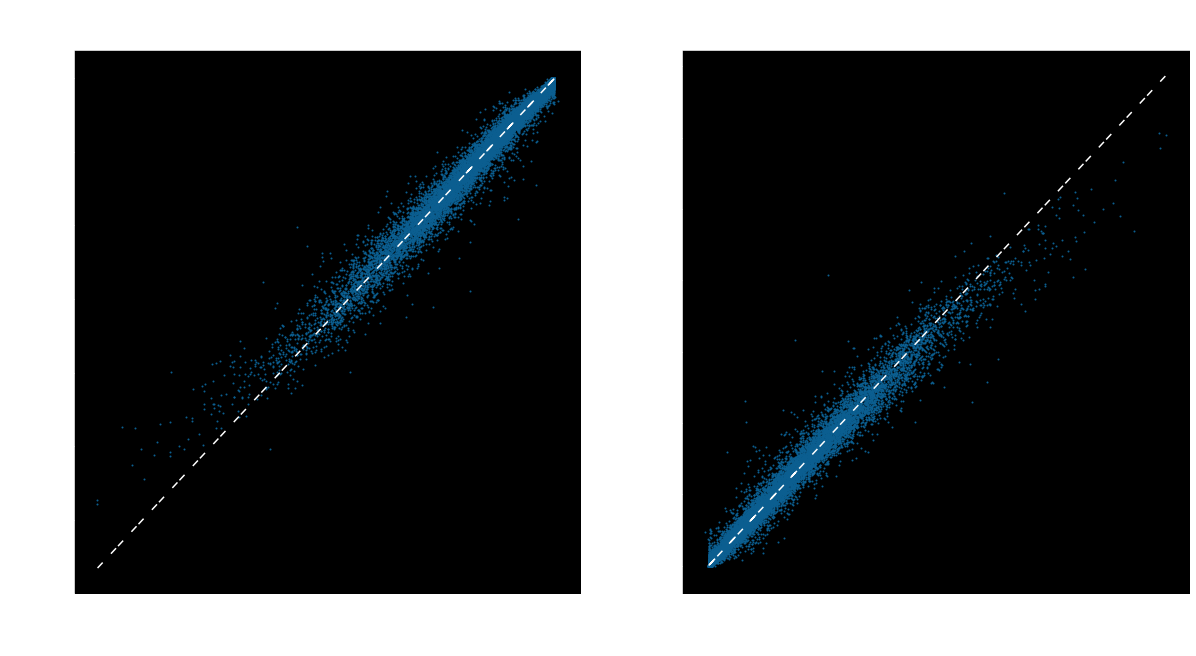

In [18]:
prep_dist.plot_duty(all_true=ordered_data, dist_col=dist_col, data_slice={"Status": "OK"})

## Temperature Benchmark

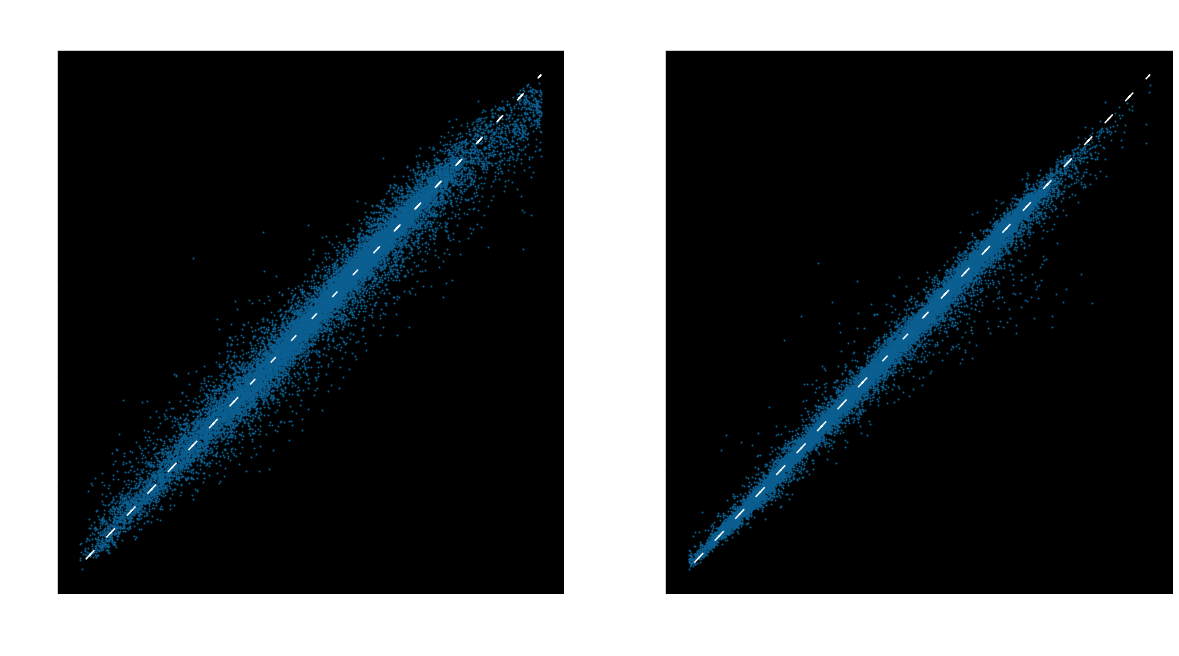

In [19]:
prep_dist.plot_temp(all_true=ordered_data, bott_stream=bott_stream.temperature, dist_stream=dist_stream.temperature, data_slice={'Status': 'OK'})

## Mean Absolute Errors

In [20]:
prep_dist.evaluate_flow(
    all_true=ordered_data, 
    y_pred=bott_stream.flow,
    metric='mae',
    data_slice={"Status": "OK"}
)

,flowrate_bott_A,flowrate_bott_B,flowrate_bott_C,mean,count
0,0.015278,0.025117,0.018302,0.019566,17782


In [21]:
prep_dist.evaluate_duty(
    all_true=ordered_data, 
    dist_col=dist_col, 
    metric='mae',
    data_slice={"Status": "OK"}
)

,condensor_duty,reboiler_duty,mean,count
0,8700.781529,9238.268734,8969.525132,17782


In [22]:
prep_dist.evaluate_temp(
    all_true=ordered_data, 
    bott_stream=bott_stream.temperature, 
    dist_stream=dist_stream.temperature, 
    data_slice={'Status': 'OK'},
    metric="mae"
)

,bott_temp,dist_temp,mean,count
0,13.116393,6.766949,9.941671,17782
